# Ray HVD TF MNIST

https://docs.ray.io/en/latest/train/examples/tf/tensorflow_mnist_example.html
Modified adding in Horovod.


Using `tensorflow-2.9.0` NERSC kernel.



In [1]:
import sys
import os

In [2]:
#!{sys.executable} -m pip install "ray[air]==2.3.1"

# Start Ray

In [3]:
from ray_utils import start_ray_cluster
ray_cluster = start_ray_cluster()

<> Starting Ray head node


In case of issues, please refer to our known issues: https://docs.nersc.gov/current/
and open a help ticket if your issue is not listed: https://help.nersc.gov/


2023-04-24 12:12:16,065	INFO usage_lib.py:435 -- Usage stats collection is disabled.
2023-04-24 12:12:16,065	INFO scripts.py:710 -- Local node IP: 128.55.64.15
2023-04-24 12:12:18,172	SUCC scripts.py:747 -- --------------------
2023-04-24 12:12:18,172	SUCC scripts.py:748 -- Ray runtime started.
2023-04-24 12:12:18,172	SUCC scripts.py:749 -- --------------------
2023-04-24 12:12:18,172	INFO scripts.py:751 -- Next steps
2023-04-24 12:12:18,172	INFO scripts.py:752 -- To connect to this Ray runtime from another node, run
2023-04-24 12:12:18,172	INFO scripts.py:755 --   ray start --address='128.55.64.15:6379'
2023-04-24 12:12:18,172	INFO scripts.py:771 -- Alternatively, use the following Python code:
2023-04-24 12:12:18,172	INFO scripts.py:773 -- import ray
2023-04-24 12:12:18,172	INFO scripts.py:777 -- ray.init(address='auto')
2023-04-24 12:12:18,172	INFO scripts.py:790 -- To see the status of the cluster, use
2023-04-24 12:12:18,172	INFO scripts.py:791 --   ray status
2023-04-24 12:12:18,

In [4]:
ray_cluster.ray.stdout

In [4]:
import ray

if ray.is_initialized:
    ray.shutdown()

ray.init(address='auto')

2023-04-24 12:12:43,349	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 128.55.64.15:6379...
2023-04-24 12:12:43,357	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.15
Ray version:,2.3.1
Dashboard:,http://127.0.0.1:8265


### Check ray cluster resources

In [5]:
ray.cluster_resources()

{'object_store_memory': 276428792217.0,
 'node:128.55.64.15': 1.0,
 'memory': 635000515175.0,
 'accelerator_type:A100': 2.0,
 'GPU': 2.0,
 'CPU': 512.0,
 'node:128.55.64.35': 1.0}

### View dashboards

In [6]:
f'https://jupyter.nersc.gov{os.getenv("JUPYTERHUB_SERVICE_PREFIX")}proxy/localhost:8265/#/new/overview'

'https://jupyter.nersc.gov/user/asnaylor/perlmutter-shared-node-cpu/proxy/localhost:8265/#/new/overview'

In [7]:
f'https://jupyter.nersc.gov{os.getenv("JUPYTERHUB_SERVICE_PREFIX")}proxy/3000/d/rayDefaultDashboard'

'https://jupyter.nersc.gov/user/asnaylor/perlmutter-shared-node-cpu/proxy/3000/d/rayDefaultDashboard'

# MINST Code

In [8]:
import numpy as np
import json
from ray.air.result import Result
import tensorflow as tf
import horovod.tensorflow.keras as hvd

# from ray.train.tensorflow import TensorflowTrainer
from ray.train.horovod import HorovodTrainer
from ray.air.integrations.keras import Callback as TrainCheckpointReportCallback
from ray.air.config import ScalingConfig, RunConfig
from ray.air import session

In [9]:
def mnist_dataset(batch_size: int) -> tf.data.Dataset:
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # The `x` arrays are in uint8 and have values in the [0, 255] range.
    # You need to convert them to float32 with values in the [0, 1] range.
    x_train = x_train / np.float32(255)
    y_train = y_train.astype(np.int64)
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .shuffle(60000)
        .repeat()
        .batch(batch_size)
    )
    return train_dataset

In [10]:
def build_cnn_model() -> tf.keras.Model:
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(28, 28)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


In [11]:

def train_func(config: dict):
    per_worker_batch_size = config.get("batch_size", 64)
    epochs = config.get("epochs", 3)
    steps_per_epoch = config.get("steps_per_epoch", 70)
    
    # Returns the total number of workers executing training.
    num_workers = session.get_world_size()
    
    # Horovod: initialize library.
    hvd.init()

    # Horovod: pin GPU to be used to process local rank (one GPU per process)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()],
                                                   'GPU')
    
    # Horovod: limit # of CPU threads to be used per worker.
    # tf.config.threading.set_intra_op_parallelism_threads(1)
    
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    global_batch_size = per_worker_batch_size * num_workers
    multi_worker_dataset = mnist_dataset(global_batch_size)

    with strategy.scope():
        # Model building/compiling need to be within `strategy.scope()`.
        multi_worker_model = build_cnn_model()
        
        # Horovod: adjust learning rate based on number of GPUs.
        learning_rate = config.get("lr", 0.001) * hvd.size()
        
        # Horovod: add Horovod DistributedOptimizer.
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        opt = hvd.DistributedOptimizer(opt)
        
        # Horovod: Specify `experimental_run_tf_function=False` to ensure TensorFlow
        # uses hvd.DistributedOptimizer() to compute gradients.
        multi_worker_model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=opt,
            metrics=["accuracy"],
            experimental_run_tf_function=False
        )
        
    callbacks = [
        TrainCheckpointReportCallback(),
    ]

    history = multi_worker_model.fit(
        multi_worker_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
    )
    # Horovod: adjust number of steps based on number of GPUs. ??
    # steps_per_epoch=500 // hvd.size(),
    results = history.history
    return results

# Run MNIST Code

In [12]:
args = {
    'num_workers': int(ray.cluster_resources()['GPU']),
    'use_gpu': True,
    'epochs': 20
}
config = {"lr": 1e-3, "batch_size": 64, "epochs": args['epochs']}

In [13]:
trainer = HorovodTrainer(
    train_loop_per_worker=train_func,
    train_loop_config=config,
    scaling_config=ScalingConfig(num_workers=args['num_workers'], use_gpu=args['use_gpu']),
    run_config=RunConfig(local_dir=f'{os.getenv("SCRATCH")}/ray_results', name='HVD_TF_MNIST')
)
results =  trainer.fit()


2023-04-24 12:13:29,480	WARNING trial_runner.py:369 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (563 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.
(RayTrainWorker pid=106009) 2023-04-24 12:13:41.040173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(RayTrainWorker pid=106009) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(RayTrainWorker pid=91742, ip=128.55.64.35) 2023-04-24 12:13:41.059901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized 

(RayTrainWorker pid=106009) Epoch 1/20


(RayTrainWorker pid=91742, ip=128.55.64.35) 2023-04-24 12:13:42.624538: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
(RayTrainWorker pid=91742, ip=128.55.64.35) op: "TensorSliceDataset"
(RayTrainWorker pid=91742, ip=128.55.64.35) input: "Placeholder/_0"
(RayTrainWorker pid=91742, ip=128.55.64.35) input: "Placeholder/_1"
(RayTrainWorker pid=91742, ip=128.55.64.35) attr {
(RayTrainWorker pid=91742, ip=128.55.64.35)   key: "Toutput_types"
(RayTrainWorker pid=91742, ip=128.55.64.35)   value {
(RayTrainWorker pid=91742, ip=128.55.64.35)     list {
(RayTrainWorker pid=91742, ip=128.55.64.35)       type: DT_FLOAT
(RayTrainWorker pid=91742, ip=128.55.64.35)       type: DT_INT64
(RayTrainWorker pid=91742, ip=128.55.64.35)     }
(RayTrainWorker pid=91742, ip=128.55.64.35)   }
(RayTrainW

(RayTrainWorker pid=91742, ip=128.55.64.35) Epoch 1/20


(RayTrainWorker pid=106009) 2023-04-24 12:13:46.299798: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
(RayTrainWorker pid=91742, ip=128.55.64.35) 2023-04-24 12:13:47.042601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
(RayTrainWorker pid=106009) 2023-04-24 12:13:47.684874: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
(RayTrainWorker pid=91742, ip=128.55.64.35) 2023-04-24 12:13:48.360038: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


60/70 [========================>.....] - ETA: 0s - loss: 2.2906 - accuracy: 0.1441


Trial name,_time_this_iter_s,_timestamp,_training_iteration,accuracy,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
HorovodTrainer_18bfd_00000,1.15471,1682363652,20,0.867857,2023-04-24_12-14-12,True,,1d84f1bbc3694c82b2dddc4f1de6d560,0,login26,20,0.499527,128.55.64.35,88796,True,36.1051,1.15698,36.1051,1682363652,0,,20,18bfd_00000,0.169468


70/70 [==============================] - 7s 6ms/step - loss: 2.2874 - accuracy: 0.1561
(RayTrainWorker pid=91742, ip=128.55.64.35) Epoch 2/20
70/70 [==============================] - 7s 6ms/step - loss: 2.2786 - accuracy: 0.1373
(RayTrainWorker pid=106009) Epoch 2/20
70/70 [==============================] - 3s 38ms/step - loss: 2.2365 - accuracy: 0.2974
(RayTrainWorker pid=91742, ip=128.55.64.35) Epoch 3/20
70/70 [==============================] - 3s 38ms/step - loss: 2.2135 - accuracy: 0.3311
(RayTrainWorker pid=106009) Epoch 3/20
70/70 [==============================] - 1s 16ms/step - loss: 2.1695 - accuracy: 0.4328
(RayTrainWorker pid=91742, ip=128.55.64.35) Epoch 4/20
70/70 [==============================] - 1s 16ms/step - loss: 2.1327 - accuracy: 0.4904
(RayTrainWorker pid=106009) Epoch 4/20
70/70 [==============================] - 1s 16ms/step - loss: 2.0902 - accuracy: 0.5218
(RayTrainWorker pid=91742, ip=128.55.64.35) Epoch 5/20
70/70 [==============================] - 1s 16ms/

(RayTrainWorker pid=106009) [2023-04-24 12:14:16.330937: E /tmp/pip-install-011ywl84/horovod_ec3ce474ca1141429eb81fcaca5161b4/horovod/common/operations.cc:654] [1]: Horovod background loop uncaught exception: [/tmp/pip-install-011ywl84/horovod_ec3ce474ca1141429eb81fcaca5161b4/third_party/gloo/gloo/transport/tcp/pair.cc:598] Connection closed by peer [128.55.64.35]:54462


(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO cudaDriverVersion 12000
(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO Bootstrap : Using hsn0:10.249.0.202<0>
(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO NET/Plugin: Failed to find ncclCollNetPlugin_v6 symbol.
(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO NET/Plugin: Failed to find ncclCollNetPlugin symbol (v4 or v5).
(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO NET/OFI Using aws-ofi-nccl 1.4.0
(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO NET/OFI Setting FI_EFA_FORK_SAFE environment variable to 1
(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO NET/OFI Selected Provider is cxi
(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO Using network AWS Libfabric
(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO NCCL_NET_GDR_LEVEL set by environment to PHB
(RayTrainWorker pid=106009) login06:106009:

(RayTrainWorker pid=106009) Exception ignored in: <function Pool.__del__ at 0x7faf0b631790>
(RayTrainWorker pid=106009) Traceback (most recent call last):
(RayTrainWorker pid=106009)   File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/multiprocessing/pool.py", line 268, in __del__
(RayTrainWorker pid=106009)   File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/multiprocessing/queues.py", line 371, in put
(RayTrainWorker pid=106009) AttributeError: 'NoneType' object has no attribute 'dumps'
(RayTrainWorker pid=106009) Exception ignored in: <function Pool.__del__ at 0x7faf0b631790>
(RayTrainWorker pid=106009) Traceback (most recent call last):
(RayTrainWorker pid=106009)   File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/multiprocessing/pool.py", line 268, in __del__
(RayTrainWorker pid=106009)   File "/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/multiprocessing/queues.p

(RayTrainWorker pid=106009) login06:106009:108081 [0] NCCL INFO comm 0x7fae9f7305a0 rank 1 nranks 2 cudaDev 0 busId c3000 - Destroy COMPLETE


2023-04-24 12:14:17,106	INFO tune.py:798 -- Total run time: 47.65 seconds (47.61 seconds for the tuning loop).


In [14]:
results

Result(metrics={'loss': 0.49952712655067444, 'accuracy': 0.8678571581840515, '_timestamp': 1682363652, '_time_this_iter_s': 1.1547129154205322, '_training_iteration': 20, 'should_checkpoint': True, 'done': True, 'trial_id': '18bfd_00000', 'experiment_tag': '0'}, error=None, log_dir=PosixPath('/pscratch/sd/a/asnaylor/ray_results/HVD_TF_MNIST/HorovodTrainer_18bfd_00000_0_2023-04-24_12-13-29'))

<AxesSubplot: xlabel='training_iteration'>

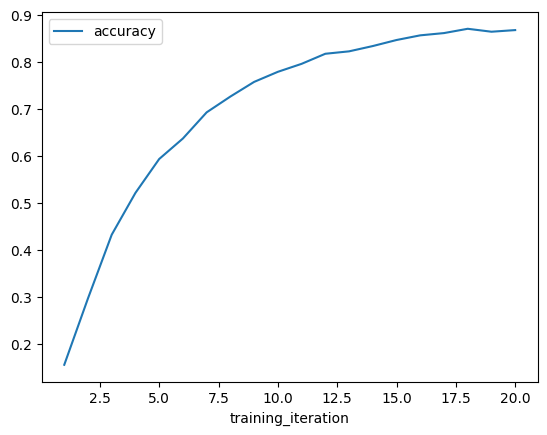

In [15]:
results.metrics_dataframe.plot("training_iteration", "accuracy")

In [16]:
from ray.train.tensorflow import TensorflowCheckpoint, TensorflowPredictor
from ray.train.batch_predictor import BatchPredictor

result_checkpoint: TensorflowCheckpoint = results.checkpoint
predictor = TensorflowPredictor.from_checkpoint(
    result_checkpoint, model_definition=build_cnn_model
)

2023-04-24 12:16:09.844251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 12:16:10.367623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2023-04-24 12:16:10,744	WARNING tensorflow_predictor.py:56 -- You have `use_gpu` as False but there are 1 GPUs detected on host where prediction will only use CPU. Please consider explicitly setting `TensorflowPredictor(use_gpu=True)` or `batch_predictor.predict(ds, num_gpus_per_worker=1)` to enable GPU prediction.


In [17]:
_, (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# The `x` arrays are in uint8 and have values in the [0, 255] range.
# You need to convert them to float32 with values in the [0, 1] range.
x_test = x_test / np.float32(255)
y_test = y_test.astype(np.int64)

2023-04-24 12:16:12.174721: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


Predicted Class = 4


2023-04-24 12:16:13.180566: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


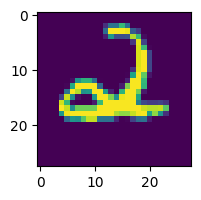

In [18]:
import matplotlib.pyplot as plt
from random import randint

img_num = randint(0, len(x_test))
test_img = x_test[img_num:img_num+1,:,:]
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape((28, 28)))

predicted_class = np.argmax(predictor.predict(test_img)['predictions'])
print("Predicted Class =", predicted_class)

### Shutdown

In [19]:
ray.shutdown()

In [20]:
ray_cluster.kill()